# Exploratory Data Analysis and Topic Modeling

This section will cover:

* initial exploratory analysis
* grammar and spelling correction 
* feature extraction with SpaCy 
* topic modeling with latent Dirichlet allocation (LDA).
* automatic scoring with LDA

In [1]:
!pip install language-tool-python
!pip install pyLDAvis

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_tool_python

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
from sklearn.model_selection import train_test_split

import pyLDAvis
from pyLDAvis.sklearn import prepare

import swifter

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

pyLDAvis.enable_notebook()
# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']= 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [3]:
try:
  training_set  = pd.read_csv('data/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
                .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
except pd.errors.ParserError as e:
        print(f"Problem file: training_set_rel3.tsv caused Exception: {e}")
        pass
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
482,485,1,"Dear @CAPS1 @CAPS2 @CAPS3, I believe that computers have a negative affect on people. Computers ...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   topic           12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   target_score    12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   topic2_target   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

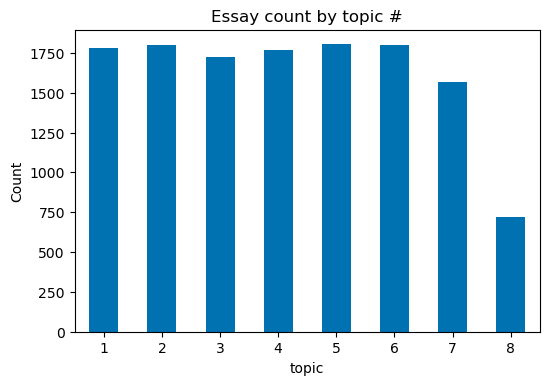

In [5]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [6]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

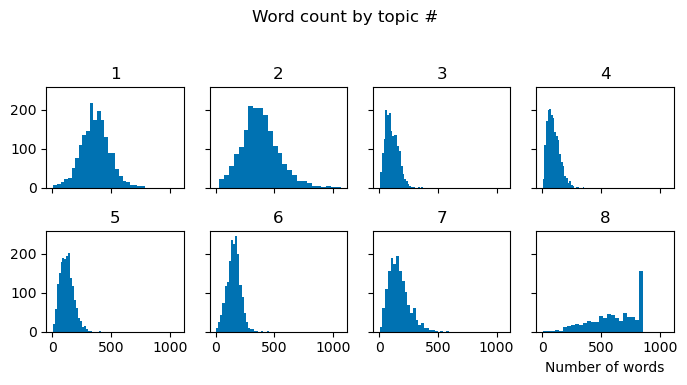

In [7]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


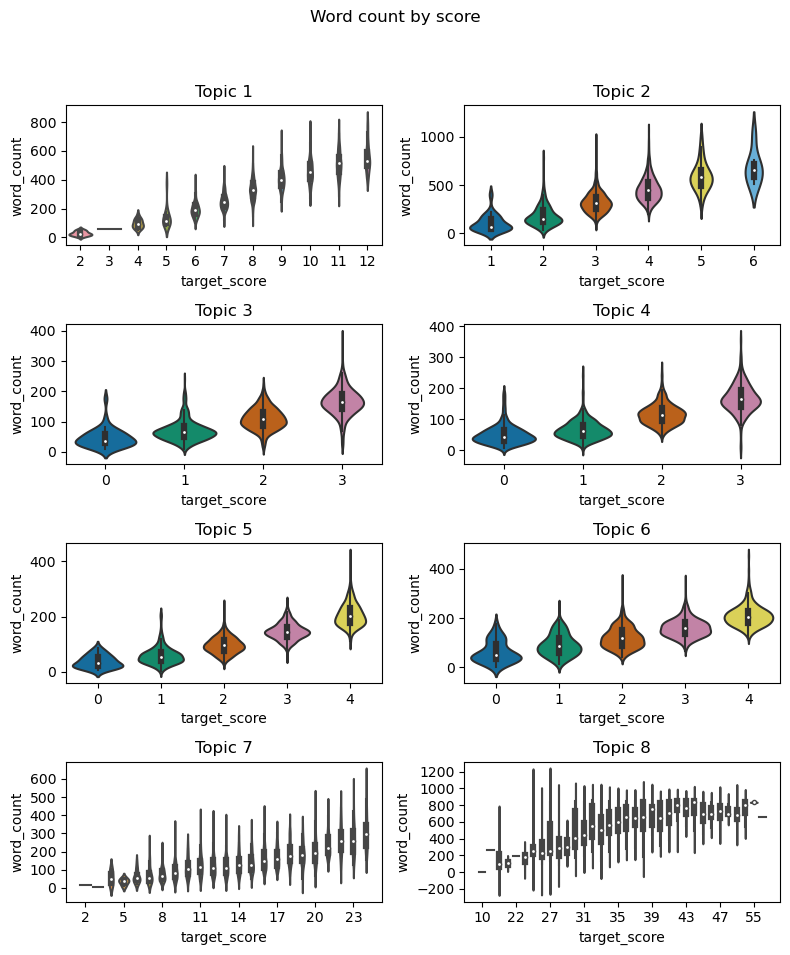

In [9]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see a reasonable correlation between word count and score for all but topic 8 where the word count apparently reaches a maximum at the upper third of the scores.

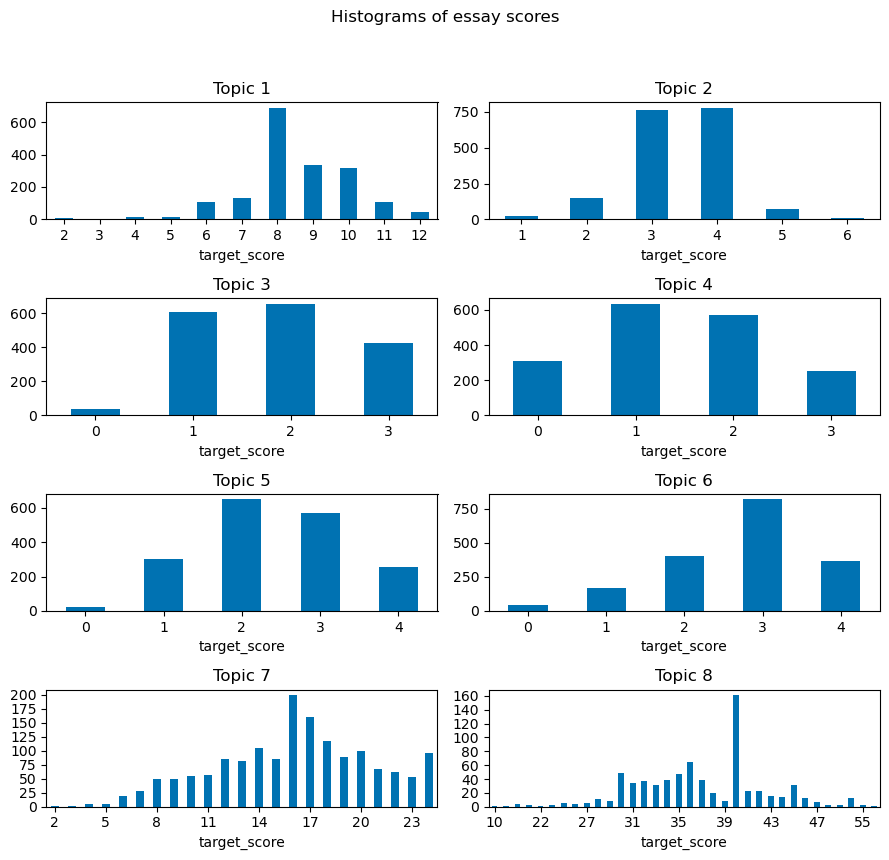

In [10]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Many scores are underrepresented. Classification could be difficult without rebalancing.

## Essay processing:

1. Language correction with languagetool (add number of corrections as feature)
2. Sentence tokenization with Spacy
3. Sentence count and length
4. Word tokenize with Spacy
5. Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6. Document similarity (based on arbitrary high scoring essay for each topic)

## Grammar and spelling

As to be expected with student essays, many essays exhibit grammar and spelling errors. 

Parts-of-speech (POS) and named-entity-recognition (NER) is hampered in part by the lack of consitent spelling and punctuation. Therefore, the essays will be corrected using languagetool and the nlp parsing will be performed with Spacy on the corrected essays.

In [11]:
text = 'Some people are still using Myspoce instead of facdbook'

Textblob is an open source nlp package and something to keep an eye on. Unlike Spacy, textblob includes a statistics based spell checker. It only claims 70% accuracy, and in my testing it didn't perform well.

https://textblob.readthedocs.io/en/dev/

In [12]:
from textblob import TextBlob
data = TextBlob(text)
print (data.correct())

Some people are still using Myspoce instead of facdbook


Languagetool.org has a python wrapper for spelling and grammatical errors at 
https://github.com/myint/language-check

It appears to work quite well, although it requires intermediate storage of a list of errors ('matches').

In [13]:
tool = language_tool_python.LanguageTool('en-US')

matches = tool.check(text)
tool.correct(text)

'Some people are still using MySpace instead of Facebook'

In [14]:
text = training_set.essay[1871]
text

'I do think that there should be a censorship in not just in libaries, but everywhare.       Personlly, I think that the way that the libraries have the books are appropite and if the parents do not want thier children going any where  that is not privy to them keep a hand lenght away     As for the parents, the parents know the aera that intrest them ,therefor the parents should go there'

In [15]:
tool.correct(text)


'I do think that there should be a censorship in not just in libraries, but everywhere.  Personally, I think that the way that the libraries have the books are appropriate and if the parents do not want their children going anywhere that is not privy to them keep a hand length away As for the parents, the parents know the area that interest them, therefor the parents should go there'

As seen in the last sentence, languagetool did not correct `",therefor"`. Nonetheless, it should be good enough to proceed.

In [16]:
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://www.languagetool.org/dev
"""
tool = language_tool_python.LanguageTool('en-US')

t0 = datetime.now()

#training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
#training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.swifter.apply(lambda l: tool.correct(l['essay']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
training_set.to_pickle('training_corr.pkl')

Pandas Apply: 100%|██████████| 12976/12976 [19:38<00:00, 11.01it/s]

Processing time: 0:23:02.447240


In [24]:
print(training_set['corrected'])
training_set['corrected'].to_csv("data/corrected_training_set_rel3",  index = False)
test = pd.read_csv("/Users/ryanbelkhir/PycharmProjects/NLP/NLP-Essay-Scoring/data/corrected_training_set_rel3")

0        Dear local newspaper, I think effects computers have on people are great learning skills/affects...
1        Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...
2        Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...
3        Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benefit ou...
4        Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...
                                                        ...                                                 
12971     In most stories mothers and daughters are either enemies or friends, in @CAPS13 story however, ...
12972     I never understood the meaning laughter is the shortest distance between two people, tell I dat...
12973    When you laugh, is @CAPS5 out of habit, or is @CAPS1 cause? What are the causes for laughing? Is...
12974     Trippin' 

Here's a very special example of poor writing skills (or perhaps a digitization error?). None of the spell checkers I tried were able to make much sense out of this.

In [42]:
print('Original:')
print(training_set.essay[18])
print('Corrected with languagetool:')
print(training_set.corrected[18])

Original:
I aegre waf the evansmant ov tnachnolage. The evansmant ov tnachnolige is being to halp fined a kohar froi alnsas. Tnanchnolage waf ont ot we wod not go to the moon. Tnachnologe evans as we maech at. The people are in tnacholege to the frchr fror the good ov live. Famas invanyor ues tnacholage leki lena orde dvanse and his fling mashine. Tnachologe is the grat
Corrected with languagetool:
I Segre weigh the evanescent of tnachnolage. The evanescent of tnachnolige is being to half fined a Zohar from Kansas. Tnanchnolage weigh on tot we won not go to the moon. Technology Evans as we match at. The people are in tnacholege to the arch for the good of live. FAMAS inventor UES anchorage Levi Lena order dance and his fling machine. Tnachologe is the great


## NLP with SpaCy

Although much of the analysis could be performed with other NLP packages, SpaCy was chosen due to its combination of speed and simplicity.

In [43]:
training_set = pd.read_pickle('training_corr.pkl')

In [44]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:05:40.733656


In [45]:
training_set.to_pickle('training_spacy.pkl')

In [46]:
training_set = pd.read_pickle('training_spacy.pkl')

In [47]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, AUX, ADP, NOUN, AUX, ADJ, NOUN, NOUN, SYM, NOUN,...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...","[@ORGANIZATION1, @ORGANIZATION2, @CAPS1, Facebook, MySpace, @DATE1, all day]"
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[ADJ, ADP, INTJ, PUNCT, PRON, VERB, SCONJ, VERB, NOUN, VERB, VERB, PRON, ADP, ADJ, NOUN, SCONJ, ...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[Dear @CAPS1 @CAPS2, Facebook and MySpace, millions, one, MySpace, Facebook, millions, @LOCATION..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[PROPN, PUNCT, X, DET, PRON, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, PART, PRON, VERB, ...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[@CAPS1 @CAPS2 @CAPS3 More, today, one, @CAPS4, one, @MONTH1, @CAPS5, thousand, @ORGANIZATION1]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[ADJ, PROPN, PROPN, PUNCT, ADP, PRON, AUX, VERB, SCONJ, ADJ, NOUN, VERB, SCONJ, NOUN, AUX, PART,...","[Dear Local Newspaper,, @CAPS1, I have found that many experts say that computers do not benefit...","[Dear Local Newspaper, @PERSON1, @PERSON2, @CAPS3, @LOCATION2, @PERCENT2 of people, @PERCENT3, @..."
4,"[Dear, @LOCATION1, ,, I, know, having, computers, has, a, positive, effect, on, people, ., The, ...","[ADJ, PROPN, PUNCT, PRON, VERB, VERB, NOUN, AUX, DET, ADJ, NOUN, ADP, NOUN, PUNCT, DET, NOUN, VE...","[Dear, @LOCATION1, I know having computers has a positive effect on people., The computers conne...","[First, one, one, Secondly, @LOCATION2, one, only one, @CAPS1]"


# Topic Modeling with Latent Dirichlet Allocation

Latent Dirichlet Allocation, or **LDA**, uses probabilities to allocate any number of documents to a pre-defined number of topics. A very good explanation is given here:

https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/

The *Hewlett ASAP* essays are already labeled as belonging to one of eight topics. A baseline excercise will determine how well essays are allocated to a topic using LDA.

A second experiment will be performed using LDA to assign scores.

Another important remark is that LDA is based on probability distributions. Probing these distributions introduces randomness so the results of running this notebook might not exactly match the comments or annotations.

To minimize confusion between the *LDA* derived topics and the *Hewlett ASAP* given topics, the given topic numbers will be replaced with a one-word summary.

LDA uses the probability of finding certain words associated with documents. Stop words will not be very helpful, for example, the word "the" is going to have a high probability across all topics. In order to refine the word list, we'll also use the lemma generated by SpaCy instead of the regular essay. As a reminder, the lemma were generated on language corrected essays.

In [48]:
# Replace topic numbers with meaningful one-word summary:
topic_dict = {'topic':{1: 'computer', 
                        2: 'censorship', 
                        3: 'cyclist', 
                        4: 'hibiscus', 
                        5: 'mood', 
                        6: 'dirigibles', 
                        7: 'patience', 
                        8: 'laughter'}}

training_set.replace(topic_dict, inplace=True)

# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

Convert essays to a matrix of token (lemma) counts:

In [52]:
# Baseline: number of unique lemma
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) # default: binary=False
doc_term_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays

# Most frequent tokens:
words = vectorizer.get_feature_names()

doc_term_matrix_df = pd.DataFrame.sparse.from_spmatrix(doc_term_matrix, columns=words)
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head(10) 

computer     20392
book         13977
building      7826
library       7624
read          6125
dirigible     6046
child         5769
help          5205
offensive     5117
talk          4969
dtype: int64

Apply LDA on the word frequency matrix.

In [53]:
lda_base = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=40,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda_base.fit(doc_term_matrix)

# save base model
joblib.dump(lda_base, 'lda_baseline.pkl')

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40, perplexity: 377.0239
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40, perplexity: 369.9156
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40, perplexity: 367.8919
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40, perplexity: 367.2625
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40, perplexity: 366.3844
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40

['lda_baseline.pkl']

Topic probabilities for all words. The numbered topics are generated from the latent Dirichlet allocation. 

In [54]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]
topics_count = lda_base.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
slavery,5.008797e-04,6.993725e-07,0.000002,0.000001,0.000001,0.000002,0.000003,0.000002
player,2.345663e-05,4.299535e-04,0.000052,0.000001,0.000369,0.000002,0.000003,0.000002
road,6.654991e-07,7.003911e-07,0.000002,0.000001,0.000066,0.000002,0.000003,0.016389
chat,6.653077e-07,6.999925e-07,0.002079,0.000001,0.005423,0.000002,0.000003,0.000002
city,1.392892e-04,1.670926e-04,0.000002,0.005071,0.000278,0.000002,0.000003,0.000096
responsible,2.523778e-04,4.402844e-05,0.000145,0.000001,0.000020,0.000052,0.000003,0.000002
dress,4.892496e-05,5.884241e-04,0.000002,0.000001,0.000016,0.000002,0.000003,0.000002
wash,7.010793e-06,2.432686e-04,0.000002,0.000001,0.000001,0.000018,0.000134,0.000018
info,6.653324e-07,7.012279e-07,0.000291,0.000001,0.000697,0.000002,0.000003,0.000031
knee,6.651941e-07,1.569013e-04,0.000002,0.000001,0.000001,0.000002,0.000003,0.000279


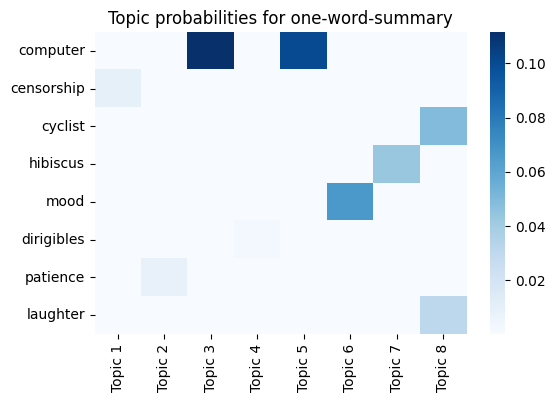

In [55]:
one_word = list(topic_dict['topic'].values())
sns.heatmap(topics.reindex(one_word), cmap='Blues')
plt.title('Topic probabilities for one-word-summary')
plt.show()

The heatmap suggests assignments for all but 1 topics. 

Below are the most probable words for each topic. We can already see our one-word summaries of the actual topic near the top of the list. 

In [56]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,book,laugh,computer,building,computer,mood,test,cyclist
1,library,patient,spend,dirigible,help,memoir,sang,water
2,read,wait,exercise,obstacle,learn,love,hibiscus,laughter
3,offensive,person1,kid,state,talk,create,paragraph,setting
4,child,caps3,outside,empire,online,narcs,conclude,affect
5,movie,caps4,bad,mast,information,grateful,plant,feature
6,shelf,tell,nature,builder,hand,happy,spring,road
7,music,start,play,face,place,rodriguez,geese,hot
8,material,mom,reason,dock,reason,house,end,hill
9,magazine,caps5,enjoy,mooring,world,paragraph,winter,desert


Now we can assign LDA topic probabilities to each essay and aggregate. It is now clear that, for example, LDA allocated topic 3 is aligned with the given topic "computers".

In [57]:
train_preds = lda_base.transform(doc_term_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=training_set.topic)
train_eval.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
topic,,,,,,,,
dirigibles,0.003473,0.003474,0.003477,0.975685,0.003473,0.003472,0.003472,0.003474
laughter,0.000677,0.688760,0.000677,0.000678,0.000678,0.032421,0.022741,0.253368
hibiscus,0.004632,0.004634,0.004631,0.004630,0.004631,0.004634,0.967576,0.004631
cyclist,0.003049,0.003050,0.003050,0.003050,0.003051,0.003050,0.003050,0.978649
hibiscus,0.006955,0.006955,0.006951,0.006949,0.006951,0.006952,0.951340,0.006948
mood,0.004321,0.004315,0.004316,0.004311,0.004315,0.969796,0.004312,0.004314
computer,0.001137,0.001137,0.683562,0.001137,0.309616,0.001137,0.001137,0.001137
hibiscus,0.004034,0.004035,0.043683,0.004032,0.004036,0.004046,0.932093,0.004040
hibiscus,0.002980,0.002981,0.002979,0.002978,0.002982,0.002980,0.979140,0.002979


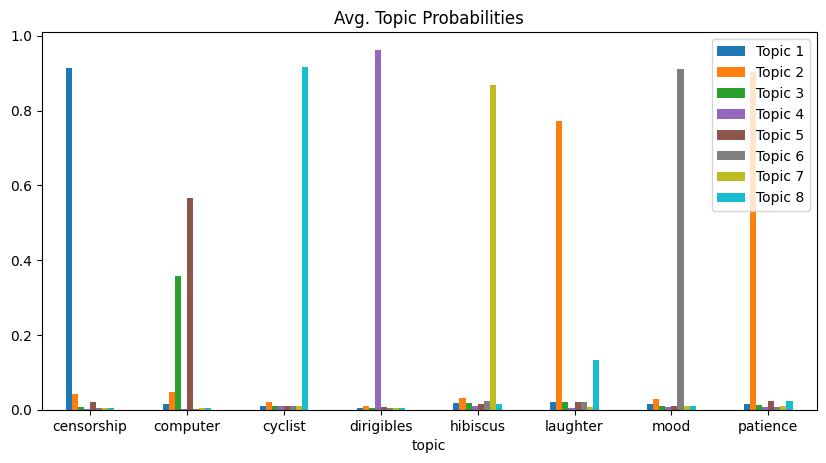

In [58]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(10,5));

The baseline model was successful in that each given topic is allocated with high probability to an LDA topic:

,topic,assignment
0,censorship,Topic 1
1,computer,Topic 5
2,cyclist,Topic 8
3,dirigibles,Topic 4
4,hibiscus,Topic 7
5,laughter,Topic 2
6,mood,Topic 6
7,patience,Topic 2


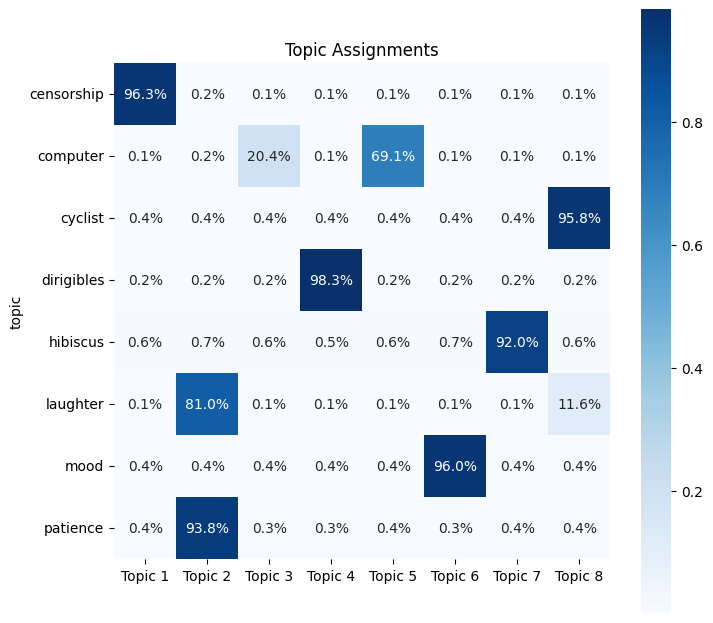

In [59]:
df = train_eval.groupby(level='topic').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Blues', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Topic Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('topic', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

## Visualization with PyLDAVis

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [60]:
prepare(lda_base, doc_term_matrix, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.125666 -0.036865       1        1  21.722537
1      0.101280  0.005777       2        1  20.600739
4      0.169791 -0.098755       3        1  14.313386
3     -0.319324 -0.205423       4        1  13.033776
7     -0.095521  0.003767       5        1   9.169467
2      0.138786 -0.118434       6        1   8.389788
5     -0.008862  0.216847       7        1   7.449849
6     -0.111816  0.233086       8        1   5.320459, topic_info=           Term          Freq         Total Category  logprob  loglift
362    computer  20482.000000  20482.000000  Default  30.0000  30.0000
204        book  13948.000000  13948.000000  Default  29.0000  29.0000
231    building   7796.000000   7796.000000  Default  28.0000  28.0000
520   dirigible   6023.000000   6023.000000  Default  27.0000  27.0000
1158       mood   4310.000000   4310.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
890        hope    355.668423   1427.473637   Topic8  -4.8607   1.5439
1705      start    441.816498   3682.672197   Topic8  -4.6438   0.8131
1443     reason    365.591380   4315.271465   Topic8  -4.8332   0.4652
301      change    309.338885   1808.661246   Topic8  -5.0003   1.1677
412     country    281.612966   1470.276257   Topic8  -5.0942   1.2809

[505 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         1  0.990015     abhor
21        1  0.018604    active
21        3  0.074415    active
21        6  0.905387    active
22        1  0.119849  activity
...     ...       ...       ...
1996      3  0.034510     young
1996      5  0.033833     young
1996      6  0.062253     young
1996      7  0.051426     young
1996      8  0.011503     young

[1311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 8, 3, 6, 7])

### "Score Allocation"

Can we take this to the next level and assign target scores based on word probabilities? To keep it simple, we'll limit the essays to topic number 4, "hibiscus". This topic has only four target scores and a reasonably balanced distribution.

In [61]:
hibiscus = training_set[training_set.topic == 'hibiscus']

# Split essays into training and test sets
train_essays, test_essays = train_test_split(hibiscus, 
                                         stratify=hibiscus.target_score, 
                                         test_size=0.2, 
                                         random_state=42)

In [62]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=400) # limit to account for smaller set of essays

# Train and test doc-term matrices
train_dtm = vectorizer.fit_transform(train_essays.l_essay)
test_dtm = vectorizer.fit_transform(test_essays.l_essay)

In [63]:
lda_score = LatentDirichletAllocation(n_components=4,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     evaluate_every=5,
                                     verbose=1, 
                                     max_iter=500)
lda_score.fit(train_dtm)

# save training model
joblib.dump(lda_score, 'lda_score.pkl')

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 278.1914
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 268.4819
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 265.0489
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 263.4927
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 262.8497
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500


['lda_score.pkl']

In [64]:
topic_labels = ['Score A', 'Score B', 'Score C', 'Score D'] #.format(i) for i in range(1, 5)]

train_preds = lda_score.transform(train_dtm)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_essays.target_score)
train_eval.sample(5)

,Score A,Score B,Score C,Score D
target_score,,,,
0,0.025526,0.025393,0.026262,0.922819
3,0.006790,0.632096,0.125416,0.235697
2,0.594034,0.390968,0.007537,0.007461
1,0.026297,0.026314,0.025787,0.921603
0,0.198511,0.206606,0.404848,0.190036


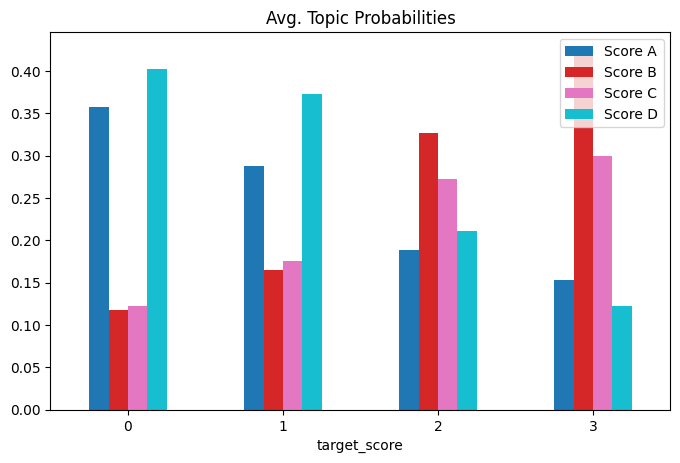

In [65]:
train_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(8,5));

,target_score,assignment
0,0,Score D
1,1,Score D
2,2,Score B
3,3,Score B


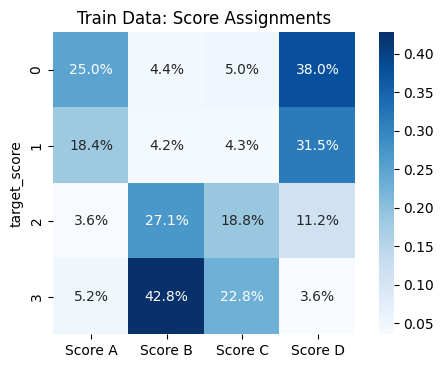

In [66]:
df = train_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Score Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('target_score', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

In [67]:
test_preds = lda_score.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_essays.target_score)
test_eval.head()

,Score A,Score B,Score C,Score D
target_score,,,,
2,0.205004,0.040307,0.503171,0.251518
3,0.186792,0.242765,0.367021,0.203422
0,0.043742,0.420921,0.353320,0.182017
1,0.218729,0.341264,0.146198,0.293809
1,0.431356,0.226562,0.312932,0.029150


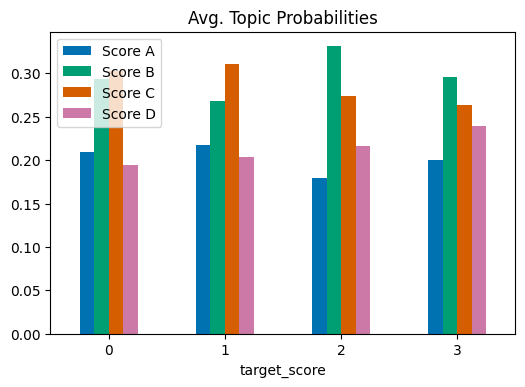

In [68]:
test_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0);

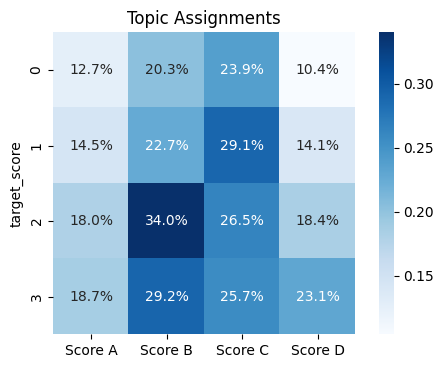

In [69]:
df = test_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments')
plt.show()

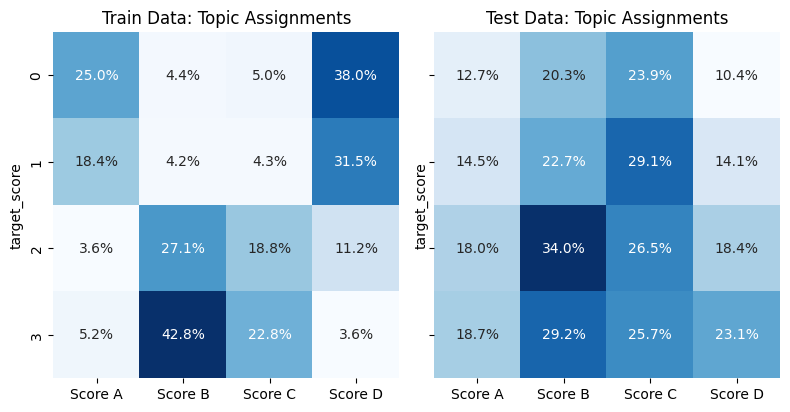

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), sharey=True)
source = ['Train', 'Test']
for i, df in enumerate([train_eval, test_eval]):
    df = df.groupby(level='target_score').agg('median')
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i], cbar=False)
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))
plt.tight_layout()
plt.show()

While the charts above are very similar to a confusion matrix, the ordering of the LDA derived topics (A,B,C,D) doesn't necessarily match the human-labeled topic ordering (0,1,2,3). Thus, the high percentages, shown here as deep blues, are not expected to be found along the diagonal. Instead the goal is to find topic distinction, indicated by a single dark square in each column, and model accuracy, indicated by identical color patterns between train and test data sets.

As seen above, there is some agreement between train and test data that essays with highest and lowest scores are distinct and assigned "Score A" and "Score B" respectively.  Overall, both topic distinction and model accuracy are rather poor. It is highly improbable this approach could be extended to any of the other topics due to the larger range of scores and class imbalance. 

Furthermore, repeated LDA runs show a lack of reproducability, which is a sign of poor distinction of topics. In summary, topic modelling, or more specifically using word frequencies and probabilities is not a useful tool to grade student essays. In the next notebook we'll continue with machine learning algorithms.